In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from linUCB_ver3 import LinUCB
import numpy as np
import matplotlib.pyplot as plt

ucb = LinUCB(alpha=0.1, max_items=100, allow_selecting_known_arms=True)

#ucb.remove_random_ratings(20)


Initializing matrix A of shape (321, 305, 305) which will require 238.8882MB of memory.

LinUCB successfully initialized.


In [2]:
ucb.A.shape
ucb.num_queries

600

In [45]:
old_avg_reward = np.append(old_avg_reward,avg_reward)
old_auc_scores = np.append(old_auc_scores,auc_scores)

In [47]:
old_auc_scores

array([0.51032222, 0.51777658, 0.5179689 , 0.52535726, 0.52884036,
       0.53308033, 0.53357309, 0.53480485, 0.54087157, 0.54309204,
       0.54515726, 0.54632352, 0.54692116, 0.54942242, 0.56157469,
       0.56420972, 0.56597817, 0.5661042 , 0.56617019, 0.56593663,
       0.56994995, 0.57005487, 0.57272412, 0.57282533, 0.57284002,
       0.57285056, 0.57697635, 0.57864933, 0.57874074, 0.58662167,
       0.58517823, 0.5876921 , 0.59204761, 0.59598311, 0.59598077,
       0.59344485, 0.59947484, 0.59952675, 0.59952679, 0.60080878,
       0.60082339, 0.60084671, 0.60738936, 0.61036213, 0.61122058,
       0.61275963, 0.6161925 , 0.62474552, 0.62604319, 0.62614003,
       0.6285718 , 0.6312717 , 0.63813215, 0.63621311, 0.63633353,
       0.63635887, 0.64601542, 0.64935378, 0.65167663, 0.65391075,
       0.66104982, 0.66039071, 0.66047715, 0.65977569, 0.66073754,
       0.6604887 , 0.66064326, 0.6606471 , 0.66166406, 0.66429627,
       0.66815572, 0.66824708, 0.66826479, 0.66938562, 0.67213

In [ ]:
# recommending page to query (30 queries)
avg_reward, auc_scores  = ucb.run(num_epochs=100)

Finished epoch 0/100 with avg reward 0.335, auc score 0.807050328829704 in 373.1575565338135s
Finished epoch 1/100 with avg reward 0.335, auc score 0.8070736165966401 in 374.7699897289276s
Finished epoch 2/100 with avg reward 0.335, auc score 0.8070829386601782 in 372.6403982639313s
Finished epoch 3/100 with avg reward 0.33666666666666667, auc score 0.8083327995466416 in 367.6512475013733s
Finished epoch 4/100 with avg reward 0.33666666666666667, auc score 0.8083651658903814 in 363.998868227005s
Finished epoch 5/100 with avg reward 0.33666666666666667, auc score 0.8083799837973491 in 364.26811122894287s
Finished epoch 6/100 with avg reward 0.3383333333333333, auc score 0.8101072526019556 in 367.30968379974365s
Finished epoch 7/100 with avg reward 0.3383333333333333, auc score 0.8101227487933969 in 372.88568687438965s
Finished epoch 8/100 with avg reward 0.3383333333333333, auc score 0.8101265924054155 in 373.13294672966003s
Finished epoch 9/100 with avg reward 0.34, auc score 0.8100035

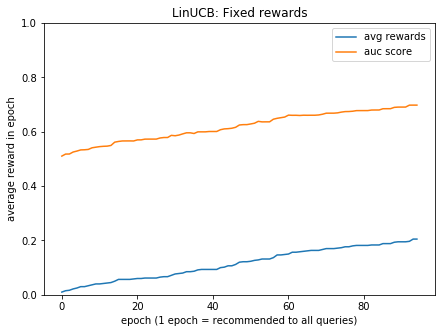

In [11]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 7, 5
plt.plot(range(len(avg_reward)), avg_reward, label='avg rewards')
plt.plot(range(len(avg_reward)), auc_scores, label='auc score')
plt.ylabel('average reward in epoch')
plt.ylim(0, 1)
plt.xlabel('epoch (1 epoch = recommended to all queries)')
plt.title('LinUCB: Fixed rewards')
plt.legend()

In [36]:
def make_prediction():
    A = ucb.A
    b = ucb.b          

    query_ids = range(ucb.num_queries)
    page_ids = range(ucb.num_articles)

    allscores=np.zeros((ucb.num_queries,ucb.num_articles))            

    for j in page_ids:
        for i in query_ids:
            # get the arm features given page id, and a query embeddings
            # though here I all queries are insample, I still use this out-of-sample arm function so it 
            # can be applied on held-out query data sets for validation in the future
            arm_features = ucb.get_featuers_of_new_query_oos(i,j)
            x_ta = arm_features.reshape(-1, 1)  # make a column vector

            A_a_inv = np.linalg.inv(A[j])
            theta_a = A_a_inv.dot(b[j])
            score_a = theta_a.T.dot(x_ta)
            allscores[i,j]=score_a  

    p_i = []
    for i in query_ids:
        #p_i.append(np.argmax(allscores[i,:]))
        p_i.append(allscores[i,:].argsort()[::-1][:10])

    return p_i

p_i = make_prediction()

In [23]:
p_i[0][0:12]

array([116, 260, 125, 223,  91, 271, 120, 179, 250, 110])

In [39]:
import pickle

acc = 0
ratings=pickle.load(open('data/Y_train_labels.pkl','rb'))

for loop in range(len(p_i)):
    
    if ratings[loop,:].argsort()[::-1][:1] in p_i[loop][0:1]:
        acc+=1
        
print(acc)

186


In [40]:
import random 

def make_prediction_oos():
    
    A = ucb.A
    b = ucb.b      
    # load the heldout data
    
    heldoutsample_label = pickle.load(open('data/Y_test_labels.pkl','rb'))
    heldoutsample_intent = pickle.load(open('data/X_test_bow_features.pkl','rb'))
    X_pca = pickle.load(open('data/X_all_page_pca_features.pkl','rb'))
    
    query_ids = range(len(heldoutsample_intent))
    page_ids = range(ucb.num_articles)

    allscores=np.zeros((len(heldoutsample_intent),ucb.num_articles)) 
    
    for j in page_ids:
        for i in query_ids:
            # get the arm features given page id, and a query embeddings
            # though here I all queries are insample, I still use this out-of-sample arm function so it 
            # can be applied on held-out query data sets for validation in the future
            
            
            query_features = heldoutsample_intent [i]
            article_features=X_pca[j,:]
            arm_features = np.concatenate((query_features, article_features), axis=0)
            x_ta = arm_features.reshape(-1, 1)  # make a column vector
            A_a_inv = np.linalg.inv(A[j])
            theta_a = A_a_inv.dot(b[j])
            score_a = theta_a.T.dot(x_ta)
            allscores[i,j]=score_a  

    p_i_test = []
    rating_test=[]
    
    for i in query_ids:
        #p_i.append(np.argmax(allscores[i,:]))
        p_i_test.append(allscores[i,:].argsort()[::-1][:10])
        rating_test.append(heldoutsample_label[i,:].argsort()[::-1])
        
    return p_i_test, rating_test

p_i_test, rating_test = make_prediction_oos()

In [41]:
acc = 0

for loop in range(len(p_i_test)):
    if rating_test[loop][0] in p_i_test[loop][0:5]:
        acc+=1
        
print(acc)
    

69


In [44]:
len(p_i_test)

200

In [29]:
ratings = pickle.load(open('./data/sample_by_question_questions_article_ratings.pkl','rb'))
ratings

[(0, 2),
 (1, 3),
 (2, 5),
 (3, 8),
 (4, 11),
 (5, 13),
 (6, 6),
 (7, 13),
 (8, 13),
 (9, 17),
 (10, 14),
 (11, 19),
 (12, 23),
 (13, 8),
 (14, 25),
 (15, 25),
 (16, 25),
 (17, 25),
 (18, 29),
 (19, 31),
 (20, 34),
 (21, 37),
 (22, 34),
 (23, 38),
 (24, 39),
 (25, 42),
 (26, 44),
 (27, 45),
 (28, 47),
 (29, 48),
 (30, 48),
 (31, 52),
 (32, 53),
 (33, 53),
 (34, 54),
 (35, 42),
 (36, 58),
 (37, 60),
 (38, 63),
 (39, 65),
 (40, 62),
 (41, 21),
 (42, 67),
 (43, 13),
 (44, 69),
 (45, 70),
 (46, 68),
 (47, 21),
 (48, 71),
 (49, 62),
 (50, 16),
 (51, 72),
 (52, 73),
 (53, 62),
 (54, 19),
 (55, 21),
 (56, 78),
 (57, 79),
 (58, 81),
 (59, 76),
 (60, 85),
 (61, 2),
 (62, 85),
 (63, 88),
 (64, 79),
 (65, 91),
 (66, 92),
 (67, 93),
 (68, 94),
 (69, 96),
 (70, 97),
 (71, 98),
 (72, 97),
 (73, 100),
 (74, 99),
 (75, 104),
 (76, 94),
 (77, 97),
 (78, 110),
 (79, 113),
 (80, 114),
 (81, 116),
 (82, 116),
 (83, 117),
 (84, 117),
 (85, 120),
 (86, 110),
 (87, 116),
 (88, 117),
 (89, 117),
 (90, 124),
 

In [12]:
ucb.dataset.get_uknown_items_of_user(1)

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 14, 15, 16, 17, 19, 20, 21, 22,
       23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98])

In [13]:
ucb.A

array([[[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]],

       [[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  2.,  0., ..., -1.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        ...,
        [ 0., -1.,  0., ...,  2.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]],

       [[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]],

       ...,

       [[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.

In [4]:
dataarray

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  1.,  0.,  0.],
       [ 2.,  1.,  1., ...,  1.,  0.,  0.],
       ...,
       [97.,  1.,  1., ...,  1.,  0.,  0.],
       [98.,  0.,  1., ...,  0.,  0.,  0.],
       [99.,  1.,  1., ...,  1.,  0.,  0.]])

In [3]:
import pickle
from sklearn.decomposition import PCA

url_features = pickle.load(open('data/infowave_allintents_title.pkl','rb'))
all_features = np.concatenate([v for k,v in url_features.items()], 0)
pca = PCA(n_components=5)
pca.fit_transform(all_features)
X_pca = pca.transform(all_features)


In [13]:
X_pca[1].transpose().shape

(5,)

In [14]:
np.concatenate([v for k,v in url_features.items()], 0).shape


(25, 768)

In [8]:
url_features.values().shape

AttributeError: 'dict_values' object has no attribute 'shape'

In [4]:
import pickle


In [11]:
a = question_features['3 Rollovers, 1 was Roth but went into a pretax account. How to fix?']
a.shape

(1, 768)

In [4]:
dict_q_mapping

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 41,
 42: 42,
 43: 43,
 44: 44,
 45: 45,
 46: 46,
 47: 47,
 48: 48,
 49: 49,
 50: 50,
 51: 51,
 52: 52,
 53: 53,
 54: 54,
 55: 55,
 57: 56,
 62: 57,
 65: 58,
 68: 59,
 71: 60,
 72: 61,
 78: 62,
 79: 63,
 126: 64,
 129: 65,
 132: 66,
 135: 67,
 137: 68,
 142: 69,
 143: 70,
 145: 71,
 150: 72,
 152: 73,
 153: 74,
 159: 75,
 160: 76,
 162: 77,
 190: 78,
 192: 79,
 197: 80,
 328: 81,
 408: 82,
 409: 83,
 410: 84,
 412: 85,
 413: 86,
 414: 87,
 417: 88,
 418: 89,
 420: 90,
 422: 91,
 423: 92,
 426: 93,
 427: 94,
 428: 95,
 435: 96,
 437: 97,
 440: 98,
 441: 99,
 443: 100,
 541: 101,
 549: 102,
 551: 103,
 552: 104,
 553: 105,
 554: 106,
 560: 1

In [17]:
import pickle

a = pickle.load(open("data/sample_by_question_query_intents.pkl","rb"))

In [18]:
a

{0: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 1: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 2: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 3: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 4: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 5: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 6: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 7: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 8: array([1., 0., 0., 0., 0., 0